In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation, Add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow import math
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [3]:
def image_generator(files, batch_size=32, sz=(256,256)):
  
  while True:

    batch = np.random.choice(files, size = batch_size)

    batch_x = []
    batch_y = []

    for f in batch:
      mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')

      mask = np.array(mask.resize(sz))
      
      # 마스크가 0,1 값만이 아닌 0,1,2로 되어있음
      # preprocess the mask
      # binary mask 만들기
      mask[mask >= 2] = 0
      mask[mask != 0] = 1

      # 결과값에 binary mask가 하나씩 들어감
      batch_y.append(mask)
      
      # preprocess the raw images
      # f해당 파일에서 다음과같은 파일을 불러옴을 뜻함.
      raw = Image.open(f'images/{f}')
      raw = np.array(raw.resize(sz))

      # check the number of channels because some of the images are RGBA or GRAY
      # len(128,128,3) 컬러 -> 3차원
      # len(128,128) 흑백 -> 2차원
      if len(raw.shape) == 2: # 흑백이냐? 라고 물어보는 것
        # 흑백과 컬러가 공존할경우 흑백을 가상의 3채널로 만들어주는것임. 
        # axis=-1은 채널을 기준으로 변경함을 뜻함
        raw = np.stack((raw,)*3, axis=-1)

      else:
        raw = raw[:,:,0:3] # RGB외에 채널이 추가될경우 3개의 채널까지만 가져옴을 뜻함.

      batch_x.append(raw)

    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y, axis=-1) # 마스크는 채널정보를 아예 가지고있지 않기 때문에 차원을 늘려 채널 값을 생성해줌

    yield (batch_x,batch_y)

In [4]:
batch_size = 32

# 파일안의 리스트들을 반환시켜줌, 섞는과정
all_files = os.listdir('images')
shuffle(all_files)

# 나눈값이 193.7 이라 가정하면 정수로만들어줌 194
# train데이터랑 test데이터 나눠줌
split = int(0.95 * len(all_files))

train_files = all_files[0:split]
test_files = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator = image_generator(test_files, batch_size = batch_size)

In [5]:
x, y = next(train_generator)

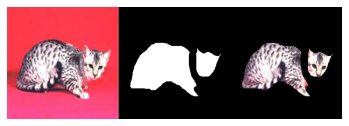

In [6]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze() # 32개중에 첫번째 선택하고 (128,128,1)가 그림그려줄 때 1은 쓸모없으므로 1을 없애주는 과정 squeeze
msk = np.stack((msk,)*3, axis=-1) # img와 msk의 곱셈을 위해 axis를 통해서 다시 채널을 쌓아줌.

plt.imshow(np.concatenate([img, msk, img*msk], axis = 1))

In [7]:
# IoU를 하면 얼마나 서로 잘 겹치느냐를 평가할 수 있음.
# 교집합/합집합
# y_true는 정답 mask 값
# y_pred는 예측한 mask 값
# 둘을 겹쳐서 segmentation이 얼마나 잘 이루어졌는지 확인
def mean_iou(y_true, y_pred):
    # B, H, W, C
    yt0 = y_true[:,:,:,0]
    # 각 픽셀마다 0~1값을 가지는데 0.5를 기준으로 물체인지 아닌지 구별해서 물체면TRUE 배경이면 FALSE
    # cast하면 TRUE값이 1.0 FALSE값이 0.0이 된다.
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    # mask Background =>0 Foreground =>1
    # inter는 교집합. 두 마스크를 true false로만들어 and연산해서 카운트해줌
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    # union는 합집합. 두 마스크를 더해주어 0이상의 값을 카운트해줌
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    # condition, x, y 값이 파라미터임 
    # condition이 true인 부분에 x를 넣고 false에 y를 넣음
    # True(배경)에 x값=1을 False(물체)에 y값inter/union을 넣음
    # 배경에는 1을 채우고 겹친부분을 
    # tf.where(  bool type 텐서,   True일 때 출력값,   False일 때 출력값  )
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [8]:
def conv_block(x, nKernels, kernel_size=3):
  conv = Conv2D(nKernels, kernel_size, kernel_initializer='he_normal', padding='same')(x)
  bn = BatchNormalization()(conv)
  act = Activation('relu')(bn)

  return act

# # 이렇게 하는 사람도 있음 sequential_model
# def conv_block(x, nKernels, kernel_size=3):
#   model = Sequential()
#   model.add(Conv2D(nkernels, kernel_size, kernel_initializer='he_normal', padding='same', input_shape=x.shape[1:])
#   model.add(BatchNormalization())
#   model.add(Activation('relu'))
  
#   return model

In [9]:
def residual_block(x, nKernels, kernel_size=3):
    y = Conv2D(nKernels, kernel_size, kernel_initializer='he_normal', strides=1, padding="same")(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(nKernels, kernel_size, kernel_initializer='he_normal', strides=1, padding="same")(y)
    
    out = Add()([x, y])
    out = BatchNormalization()(out)

    return Activation('relu')(out)

In [10]:
def squeeze_and_excitation_block(x, ratio = 8):
  filters = x.shape[-1]
  init = x

  global_avg = tf.keras.layers.GlobalAveragePooling2D()(x)
  squeeze = tf.keras.layers.Reshape((1,1,filters))(global_avg)
  squeeze = tf.keras.layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(squeeze)
  squeeze = tf.keras.layers.Dense(filters, activation='sigmoid')(squeeze)
  return tf.keras.layers.Multiply()([init, squeeze])

In [11]:
def dense_block(x, nKernels, kernel_size=3):
  dense_block_1     = Conv2D(nKernels, 3 , strides=1,name='dense_block_1' , activation='selu', padding='same', kernel_initializer='lecun_normal')(x)
  dense_block_2     = Conv2D(nKernels, 3 , strides=1,name='dense_block_2' , padding='same', activation='selu', kernel_initializer='lecun_normal')(dense_block_1)
  dense_block_add1  = Concatenate()([x, dense_block_2])
  dense_block_3     = Conv2D(nKernels, 3 , strides=1,name='dense_block_3' , padding='same', activation='selu', kernel_initializer='lecun_normal')(dense_block_add1)
  dense_block_add2  = Concatenate()([x, dense_block_1, dense_block_3])
  dense_block_4     = Conv2D(nKernels, 3 , strides=1,name='dense_block_4' , padding='same', activation='selu', kernel_initializer='lecun_normal')(dense_block_add2)
  dense_block_add3  = Concatenate()([x, dense_block_1, dense_block_2, dense_block_4])
  dense_block_5     = Conv2D(nKernels, 3 , strides=1,name='dense_block_5' , padding='same', activation='selu', kernel_initializer='lecun_normal')(dense_block_add3)
  dense_block_add4  = Concatenate()([x, dense_block_1, dense_block_2, dense_block_3, dense_block_5])
  dense_block_6     = Conv2D(nKernels, 3 , strides=1,name='dense_block_6' , padding='same', activation='selu', kernel_initializer='lecun_normal')(dense_block_add4)
  dense_block_add5  = Concatenate()([x, dense_block_1, dense_block_2, dense_block_3, dense_block_4, dense_block_6])

  return dense_block_add5

In [12]:
# UNet Network 설계

def unet(sz = (256, 256, 3)):
  # input layer

  nkernels =32

  x = Input(sz)
  inputs = x # 어떤역할?

  # (256,256,3) 나중에 픽셀 사이즈를 맞추는 계산을 쉽게 해주기 위해 padding='same'을 해줌
  # maxpooling의 default값이 (2,2)여서 지정안해도 됨.
  layer1_1 = Conv2D(nkernels,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(x)
  layer1_2 = Conv2D(nkernels,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(layer1_1)
  layer1_3 = MaxPooling2D()(layer1_2)

  # (128,128,32)
  layer2_1 = Conv2D(nkernels*2,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(layer1_3)
  layer2_2 = Conv2D(nkernels*2,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(layer2_1)
  layer2_3 = MaxPooling2D()(layer2_2)

  # (64,64,64)
  layer3_1 = Conv2D(nkernels*4,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(layer2_3)
  layer3_2 = Conv2D(nkernels*4,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(layer3_1)
  layer3_3 = MaxPooling2D()(layer3_2)

  # (32,32,128)
  layer4_1 = Conv2D(nkernels*8,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(layer3_3)
  layer4_2 = Conv2D(nkernels*8,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(layer4_1)
  layer4_3 = MaxPooling2D()(layer4_2)

  # (16,16,256)
  layer5_1 = Conv2D(nkernels*16,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(layer4_3)
  layer5_2 = Conv2D(nkernels*16,(3,3),kernel_initializer='he_normal',activation='relu', padding='same')(layer5_1)
  layer5_3 = MaxPooling2D()(layer5_2) # (16,16,512)

  # bottle neck
  # (8,8,512)
  bottleneck = Conv2D(nkernels*32, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(layer5_3)
  # (8,8,1024)
  bottleneck2 = Conv2D(nkernels*16, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(bottleneck)
  # (8,8,512)

  layer6_1 = UpSampling2D()(bottleneck2)
  # (16,16 512)
  layer6_2 = Concatenate(axis=-1)([layer6_1, layer5_2]) # default가 채널축으르 붙여주나 이해를 위해 써주는것
  # (16,16,1024)
  layer6_3 = Conv2D(nkernels*16, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(layer6_2)
  layer6_4 = Conv2D(nkernels*8, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer6_3)

  layer7_1 = UpSampling2D()(layer6_4) # (32,32,256)
  layer7_2 = Concatenate()([layer7_1, layer4_2])
  layer7_3 = Conv2D(nkernels*8, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer7_2)
  layer7_4 = Conv2D(nkernels*4, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer7_3)

  layer8_1 = UpSampling2D()(layer7_4) # (64,64,128)
  layer8_2 = Concatenate()([layer8_1, layer3_2])
  layer8_3 = Conv2D(nkernels*4, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer8_2)
  layer8_4 = Conv2D(nkernels*2, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer8_3)

  layer9_1 = UpSampling2D()(layer8_4) # (128,128,64)
  layer9_2 = Concatenate()([layer9_1, layer2_2])
  layer9_3 = Conv2D(nkernels*2, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer9_2)
  layer9_4 = Conv2D(nkernels, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer9_3)

  layer10_1 = UpSampling2D()(layer9_4) # (256,256,32)
  layer10_2 = Concatenate()([layer10_1, layer1_2])
  layer10_3 = Conv2D(nkernels, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer10_2)
  
  last = Conv2D(1, (1,1), activation='sigmoid', padding='same')(layer10_3) # sigmoid,tanh DEFAULT KERNEL_INITIALIZER
  # 마스크는 항상 1채널로 생각.
  # categorical로 표현하면 conv2D(2, ...)로 뽑아야함.

  #model creation 
  model = Model(inputs=[inputs], outputs=[last])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [13]:
# UNet Network 설계

def unet_bn(sz = (256, 256, 3)):
  # input layer

  nkernels =32

  x = Input(sz)
  inputs = x # 어떤역할?

  # (256,256,3) 나중에 픽셀 사이즈를 맞추는 계산을 쉽게 해주기 위해 padding='same'을 해줌
  # maxpooling의 default값이 (2,2)여서 지정안해도 됨.
  layer1_1 = conv_block(x, nKernels = nkernels)
  layer1_2 = conv_block(layer1_1, nKernels = nkernels)
  layer1_3 = MaxPooling2D()(layer1_2)

  # (128,128,32)
  layer2_1 = conv_block(layer1_3, nKernels = nkernels*2)
  layer2_2 = conv_block(layer2_1, nKernels = nkernels*2)
  layer2_3 = MaxPooling2D()(layer2_2)

  # (64,64,64)
  layer3_1 = conv_block(layer2_3, nKernels = nkernels*4)
  layer3_2 = conv_block(layer3_1, nKernels = nkernels*4)
  layer3_3 = MaxPooling2D()(layer3_2)

  # (32,32,128)
  layer4_1 = conv_block(layer3_3, nKernels = nkernels*8)
  layer4_2 = conv_block(layer4_1, nKernels = nkernels*8)
  layer4_3 = MaxPooling2D()(layer4_2)

  # (16,16,256)
  layer5_1 = conv_block(layer4_3, nKernels = nkernels*16)
  layer5_2 = conv_block(layer5_1, nKernels = nkernels*16)
  layer5_3 = MaxPooling2D()(layer5_2) # (16,16,512)

  # bottle neck
  # (8,8,512)
  bottleneck = conv_block(layer5_3, nKernels = nkernels*32)
  # (8,8,1024)
  bottleneck2 = conv_block(bottleneck, nKernels = nkernels*16)
  # (8,8,512)

  layer6_1 = UpSampling2D()(bottleneck2)
  # (16,16 512)
  layer6_2 = Concatenate(axis=-1)([layer6_1, layer5_2]) # default가 채널축으르 붙여주나 이해를 위해 써주는것
  # (16,16,1024)
  layer6_3 = conv_block(layer6_2, nKernels = nkernels*16)
  layer6_4 = conv_block(layer6_3, nKernels = nkernels*8)

  layer7_1 = UpSampling2D()(layer6_4) # (32,32,256)
  layer7_2 = Concatenate()([layer7_1, layer4_2])
  layer7_3 = conv_block(layer7_2, nKernels = nkernels*8)
  layer7_4 = conv_block(layer7_3, nKernels = nkernels*4)

  layer8_1 = UpSampling2D()(layer7_4) # (64,64,128)
  layer8_2 = Concatenate()([layer8_1, layer3_2])
  layer8_3 = conv_block(layer8_2, nKernels = nkernels*4)
  layer8_4 = conv_block(layer8_3, nKernels = nkernels*2)

  layer9_1 = UpSampling2D()(layer8_4) # (128,128,64)
  layer9_2 = Concatenate()([layer9_1, layer2_2])
  layer9_3 = conv_block(layer9_2, nKernels = nkernels*2)
  layer9_4 = conv_block(layer9_3, nKernels = nkernels)

  layer10_1 = UpSampling2D()(layer9_4) # (256,256,32)
  layer10_2 = Concatenate()([layer10_1, layer1_2])
  layer10_3 = conv_block(layer10_2, nKernels = nkernels)
  
  last = Conv2D(1, (1,1), activation='sigmoid', padding='same')(layer10_3) # sigmoid,tanh DEFAULT KERNEL_INITIALIZER
  # 마스크는 항상 1채널로 생각.
  # categorical로 표현하면 conv2D(2, ...)로 뽑아야함.

  #model creation 
  model = Model(inputs=[inputs], outputs=[last])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [14]:
# UNet Network 설계

def unet_residual(sz = (256, 256, 3)):
  # input layer

  nkernels =32

  x = Input(sz)
  inputs = x # 어떤역할?

  # (256,256,3) 나중에 픽셀 사이즈를 맞추는 계산을 쉽게 해주기 위해 padding='same'을 해줌
  # maxpooling의 default값이 (2,2)여서 지정안해도 됨.
  layer1_1 = conv_block(x, nKernels = nkernels)
  layer1_2 = conv_block(layer1_1, nKernels = nkernels)
  layer1_3 = MaxPooling2D()(layer1_2)
  

  # (128,128,32)
  layer2_1 = conv_block(layer1_3, nKernels = nkernels*2)
  layer2_2 = residual_block(layer2_1, nKernels = nkernels*2)
  layer2_3 = MaxPooling2D()(layer2_2)

  # (64,64,64)
  layer3_1 = conv_block(layer2_3, nKernels = nkernels*4)
  layer3_2 = residual_block(layer3_1, nKernels = nkernels*4)
  layer3_3 = MaxPooling2D()(layer3_2)

  # (32,32,128)
  layer4_1 = conv_block(layer3_3, nKernels = nkernels*8)
  layer4_2 = residual_block(layer4_1, nKernels = nkernels*8)
  layer4_3 = MaxPooling2D()(layer4_2)

  # (16,16,256)
  layer5_1 = conv_block(layer4_3, nKernels = nkernels*16)
  layer5_2 = residual_block(layer5_1, nKernels = nkernels*16)
  layer5_3 = MaxPooling2D()(layer5_2) # (16,16,512)

  # bottle neck
  # (8,8,512)
  bottleneck = conv_block(layer5_3, nKernels = nkernels*32)
  # (8,8,1024)
  bottleneck2 = conv_block(bottleneck, nKernels = nkernels*16)
  # (8,8,512)

  layer6_1 = UpSampling2D()(bottleneck2)
  # (16,16 512)
  layer6_2 = Concatenate(axis=-1)([layer6_1, layer5_2]) # default가 채널축으르 붙여주나 이해를 위해 써주는것
  # (16,16,1024)
  layer6_3 = conv_block(layer6_2, nKernels = nkernels*16)
  layer6_4 = conv_block(layer6_3, nKernels = nkernels*8)

  layer7_1 = UpSampling2D()(layer6_4) # (32,32,256)
  layer7_2 = Concatenate()([layer7_1, layer4_2])
  layer7_3 = conv_block(layer7_2, nKernels = nkernels*8)
  layer7_4 = conv_block(layer7_3, nKernels = nkernels*4)

  layer8_1 = UpSampling2D()(layer7_4) # (64,64,128)
  layer8_2 = Concatenate()([layer8_1, layer3_2])
  layer8_3 = conv_block(layer8_2, nKernels = nkernels*4)
  layer8_4 = conv_block(layer8_3, nKernels = nkernels*2)

  layer9_1 = UpSampling2D()(layer8_4) # (128,128,64)
  layer9_2 = Concatenate()([layer9_1, layer2_2])
  layer9_3 = conv_block(layer9_2, nKernels = nkernels*2)
  layer9_4 = conv_block(layer9_3, nKernels = nkernels)

  layer10_1 = UpSampling2D()(layer9_4) # (256,256,32)
  layer10_2 = Concatenate()([layer10_1, layer1_2])
  layer10_3 = conv_block(layer10_2, nKernels = nkernels)
  
  last = Conv2D(1, (1,1), activation='sigmoid', padding='same')(layer10_3) # sigmoid,tanh DEFAULT KERNEL_INITIALIZER
  # 마스크는 항상 1채널로 생각.
  # categorical로 표현하면 conv2D(2, ...)로 뽑아야함.

  #model creation 
  model = Model(inputs=[inputs], outputs=[last])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [15]:
# UNet Network 설계

def unet_residual_SE(sz = (256, 256, 3)):
  # input layer

  nkernels =32

  x = Input(sz)
  inputs = x # 어떤역할?

  # (256,256,3) 나중에 픽셀 사이즈를 맞추는 계산을 쉽게 해주기 위해 padding='same'을 해줌
  # maxpooling의 default값이 (2,2)여서 지정안해도 됨.
  layer1_1 = conv_block(x, nKernels = nkernels)
  layer1_2 = conv_block(layer1_1, nKernels = nkernels)
  layer1_2 = squeeze_and_excitation_block(layer1_2)
  layer1_3 = MaxPooling2D()(layer1_2)
  

  # (128,128,32)
  layer2_1 = conv_block(layer1_3, nKernels = nkernels*2)
  layer2_2 = residual_block(layer2_1, nKernels = nkernels*2)
  layer2_2 = squeeze_and_excitation_block(layer2_2)
  layer2_3 = MaxPooling2D()(layer2_2)

  # (64,64,64)
  layer3_1 = conv_block(layer2_3, nKernels = nkernels*4)
  layer3_2 = residual_block(layer3_1, nKernels = nkernels*4)
  layer3_2 = squeeze_and_excitation_block(layer3_2)
  layer3_3 = MaxPooling2D()(layer3_2)

  # (32,32,128)
  layer4_1 = conv_block(layer3_3, nKernels = nkernels*8)
  layer4_2 = residual_block(layer4_1, nKernels = nkernels*8)
  layer4_2 = squeeze_and_excitation_block(layer4_2)
  layer4_3 = MaxPooling2D()(layer4_2)

  # (16,16,256)
  layer5_1 = conv_block(layer4_3, nKernels = nkernels*16)
  layer5_2 = residual_block(layer5_1, nKernels = nkernels*16)
  layer5_2 = squeeze_and_excitation_block(layer5_2)
  layer5_3 = MaxPooling2D()(layer5_2) # (16,16,512)

  # bottle neck
  # (8,8,512)
  bottleneck = conv_block(layer5_3, nKernels = nkernels*32)
  # (8,8,1024)
  bottleneck2 = conv_block(bottleneck, nKernels = nkernels*16)
  # (8,8,512)

  layer6_1 = UpSampling2D()(bottleneck2)
  # (16,16 512)
  layer6_2 = Concatenate(axis=-1)([layer6_1, layer5_2]) # default가 채널축으르 붙여주나 이해를 위해 써주는것
  # (16,16,1024)
  layer6_3 = conv_block(layer6_2, nKernels = nkernels*16)
  layer6_4 = conv_block(layer6_3, nKernels = nkernels*8)
  layer6_4 = squeeze_and_excitation_block(layer6_4)

  layer7_1 = UpSampling2D()(layer6_4) # (32,32,256)
  layer7_2 = Concatenate()([layer7_1, layer4_2])
  layer7_3 = conv_block(layer7_2, nKernels = nkernels*8)
  layer7_4 = conv_block(layer7_3, nKernels = nkernels*4)
  layer7_4 = squeeze_and_excitation_block(layer7_4)

  layer8_1 = UpSampling2D()(layer7_4) # (64,64,128)
  layer8_2 = Concatenate()([layer8_1, layer3_2])
  layer8_3 = conv_block(layer8_2, nKernels = nkernels*4)
  layer8_4 = conv_block(layer8_3, nKernels = nkernels*2)
  layer8_4 = squeeze_and_excitation_block(layer8_4)

  layer9_1 = UpSampling2D()(layer8_4) # (128,128,64)
  layer9_2 = Concatenate()([layer9_1, layer2_2])
  layer9_3 = conv_block(layer9_2, nKernels = nkernels*2)
  layer9_4 = conv_block(layer9_3, nKernels = nkernels)
  layer9_4 = squeeze_and_excitation_block(layer9_4)

  layer10_1 = UpSampling2D()(layer9_4) # (256,256,32)
  layer10_2 = Concatenate()([layer10_1, layer1_2])
  layer10_3 = conv_block(layer10_2, nKernels = nkernels)
  
  last = Conv2D(1, (1,1), activation='sigmoid', padding='same')(layer10_3) # sigmoid,tanh DEFAULT KERNEL_INITIALIZER
  # 마스크는 항상 1채널로 생각.
  # categorical로 표현하면 conv2D(2, ...)로 뽑아야함.

  #model creation 
  model = Model(inputs=[inputs], outputs=[last])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [16]:
def unet_dense(sz = (256, 256, 3)):
  # input layer

  nkernels =32

  x = Input(sz)
  inputs = x # 어떤역할?

  # (256,256,3) 나중에 픽셀 사이즈를 맞추는 계산을 쉽게 해주기 위해 padding='same'을 해줌
  # maxpooling의 default값이 (2,2)여서 지정안해도 됨.
  layer1_1 = conv_block(x, nKernels = nkernels)
  layer1_2 = conv_block(layer1_1, nKernels = nkernels)
  layer1_2 = squeeze_and_excitation_block(layer1_2)
  layer1_2 = dense_block(layer1_2, nKernels = nkernels)
  layer1_3 = MaxPooling2D()(layer1_2)
  

  # (128,128,32)
  layer2_1 = conv_block(layer1_3, nKernels = nkernels*2)
  layer2_2 = residual_block(layer2_1, nKernels = nkernels*2)
  layer2_2 = squeeze_and_excitation_block(layer2_2)
  layer2_2 = dense_block(layer2_2, nKernels = nkernels*2)
  layer2_3 = MaxPooling2D()(layer2_2)

  # (64,64,64)
  layer3_1 = conv_block(layer2_3, nKernels = nkernels*4)
  layer3_2 = residual_block(layer3_1, nKernels = nkernels*4)
  layer3_2 = squeeze_and_excitation_block(layer3_2)
  layer3_2 = dense_block(layer3_2, nKernels = nkernels*4)
  layer3_3 = MaxPooling2D()(layer3_2)

  # (32,32,128)
  layer4_1 = conv_block(layer3_3, nKernels = nkernels*8)
  layer4_2 = residual_block(layer4_1, nKernels = nkernels*8)
  layer4_2 = squeeze_and_excitation_block(layer4_2)
  layer4_2 = dense_block(layer4_2, nKernels*8)
  layer4_3 = MaxPooling2D()(layer4_2)

  # (16,16,256)
  layer5_1 = conv_block(layer4_3, nKernels = nkernels*16)
  layer5_2 = residual_block(layer5_1, nKernels = nkernels*16)
  layer5_2 = squeeze_and_excitation_block(layer5_2)
  layer5_2 = dense_block(layer5_2, nKernels = nkernels*16)
  layer5_3 = MaxPooling2D()(layer5_2) # (16,16,512)

  # bottle neck
  # (8,8,512)
  bottleneck = conv_block(layer5_3, nKernels = nkernels*32)
  # (8,8,1024)
  bottleneck2 = conv_block(bottleneck, nKernels = nkernels*16)
  # (8,8,512)

  layer6_1 = UpSampling2D()(bottleneck2)
  # (16,16 512)
  layer6_2 = Concatenate(axis=-1)([layer6_1, layer5_2]) # default가 채널축으르 붙여주나 이해를 위해 써주는것
  # (16,16,1024)
  layer6_3 = conv_block(layer6_2, nKernels = nkernels*16)
  layer6_4 = conv_block(layer6_3, nKernels = nkernels*8)
  layer6_4 = dense_block(layer6_4, nKernels = nkernels*8)
  layer6_4 = squeeze_and_excitation_block(layer6_4)

  layer7_1 = UpSampling2D()(layer6_4) # (32,32,256)
  layer7_2 = Concatenate()([layer7_1, layer4_2])
  layer7_3 = conv_block(layer7_2, nKernels = nkernels*8)
  layer7_4 = conv_block(layer7_3, nKernels = nkernels*4)
  layer7_4 = dense_block(layer7_4, nKernels = nkernels*4)
  layer7_4 = squeeze_and_excitation_block(layer7_4)

  layer8_1 = UpSampling2D()(layer7_4) # (64,64,128)
  layer8_2 = Concatenate()([layer8_1, layer3_2])
  layer8_3 = conv_block(layer8_2, nKernels = nkernels*4)
  layer8_4 = conv_block(layer8_3, nKernels = nkernels*2)
  layer8_4 = dense_block(layer8_4, nKernels = nkernels*2)
  layer8_4 = squeeze_and_excitation_block(layer8_4)

  layer9_1 = UpSampling2D()(layer8_4) # (128,128,64)
  layer9_2 = Concatenate()([layer9_1, layer2_2])
  layer9_3 = conv_block(layer9_2, nKernels = nkernels*2)
  layer9_4 = conv_block(layer9_3, nKernels = nkernels)
  layer9_4 = dense_block(layer9_4, nKernels = nkernels)
  layer9_4 = squeeze_and_excitation_block(layer9_4)

  layer10_1 = UpSampling2D()(layer9_4) # (256,256,32)
  layer10_2 = Concatenate()([layer10_1, layer1_2])
  layer10_3 = conv_block(layer10_2, nKernels = nkernels)
  
  last = Conv2D(1, (1,1), activation='sigmoid', padding='same')(layer10_3) # sigmoid,tanh DEFAULT KERNEL_INITIALIZER
  # 마스크는 항상 1채널로 생각.
  # categorical로 표현하면 conv2D(2, ...)로 뽑아야함.

  #model creation 
  model = Model(inputs=[inputs], outputs=[last])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [17]:
model = unet_residual_SE()

In [18]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

i= 1 loss= 0.4395495057106018 val_loss= 1.0656647682189941 mean_iou= 0.47199711203575134 val_mean_iou= 0.4396086633205414


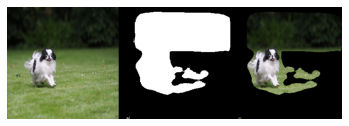

i= 2 loss= 0.3052349388599396 val_loss= 0.38018134236335754 mean_iou= 0.6277359127998352 val_mean_iou= 0.6445170640945435


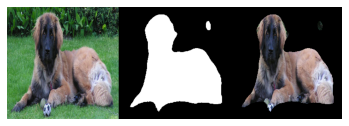

i= 3 loss= 0.23636259138584137 val_loss= 0.23701001703739166 mean_iou= 0.7105166912078857 val_mean_iou= 0.7220615744590759


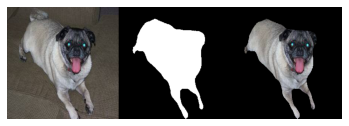

i= 4 loss= 0.2043168991804123 val_loss= 0.22809487581253052 mean_iou= 0.7519460320472717 val_mean_iou= 0.7558647394180298


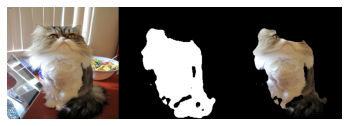

i= 5 loss= 0.1848250776529312 val_loss= 0.18768788874149323 mean_iou= 0.772238552570343 val_mean_iou= 0.7781171798706055


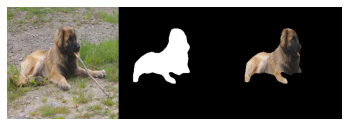

i= 6 loss= 0.1726561039686203 val_loss= 0.2099461406469345 mean_iou= 0.787936270236969 val_mean_iou= 0.773963987827301


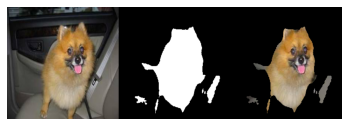

i= 7 loss= 0.15957783162593842 val_loss= 0.19900302588939667 mean_iou= 0.8054726123809814 val_mean_iou= 0.766024649143219


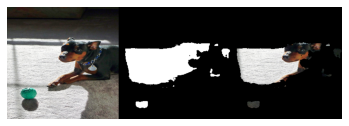

i= 8 loss= 0.1479218751192093 val_loss= 0.14246053993701935 mean_iou= 0.8174117803573608 val_mean_iou= 0.8245849013328552


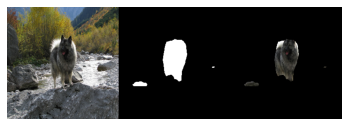

i= 9 loss= 0.1416921466588974 val_loss= 0.13386812806129456 mean_iou= 0.8246427774429321 val_mean_iou= 0.8325194716453552


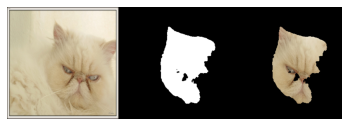

i= 10 loss= 0.13616612553596497 val_loss= 0.1689453423023224 mean_iou= 0.833929181098938 val_mean_iou= 0.8044252395629883


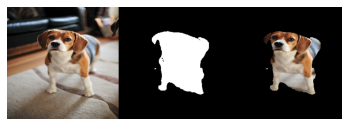

i= 11 loss= 0.1295919269323349 val_loss= 0.16579844057559967 mean_iou= 0.8385474681854248 val_mean_iou= 0.8005889654159546


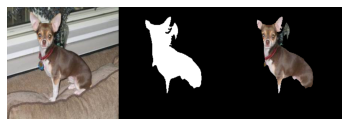

i= 12 loss= 0.12451988458633423 val_loss= 0.23116439580917358 mean_iou= 0.8447938561439514 val_mean_iou= 0.7329598069190979


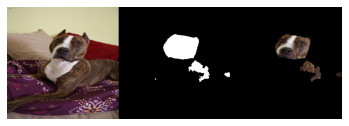

i= 13 loss= 0.12035394459962845 val_loss= 0.1409352868795395 mean_iou= 0.8513104319572449 val_mean_iou= 0.8239091634750366


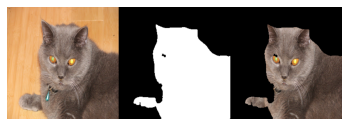

i= 14 loss= 0.11692527681589127 val_loss= 0.15313930809497833 mean_iou= 0.8548465967178345 val_mean_iou= 0.8298494219779968


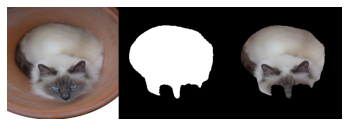

i= 15 loss= 0.11351817101240158 val_loss= 0.14669625461101532 mean_iou= 0.8600508570671082 val_mean_iou= 0.8255540728569031


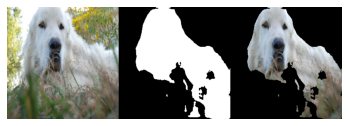

i= 16 loss= 0.1062067449092865 val_loss= 0.155783548951149 mean_iou= 0.8656221628189087 val_mean_iou= 0.8261513113975525


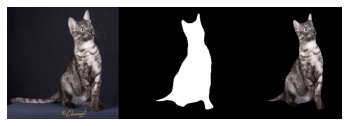

i= 17 loss= 0.10622921586036682 val_loss= 0.1859230399131775 mean_iou= 0.8657405376434326 val_mean_iou= 0.8029497265815735


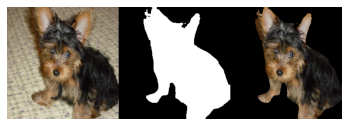

i= 18 loss= 0.09948420524597168 val_loss= 0.1291830688714981 mean_iou= 0.8724294304847717 val_mean_iou= 0.8267350792884827


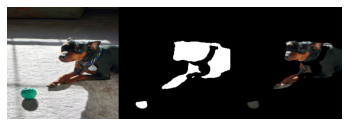

i= 19 loss= 0.09917362779378891 val_loss= 0.14644788205623627 mean_iou= 0.874514102935791 val_mean_iou= 0.8237394690513611


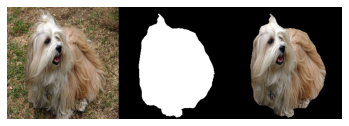

i= 20 loss= 0.09642499685287476 val_loss= 0.1418842375278473 mean_iou= 0.8764848113059998 val_mean_iou= 0.837419331073761


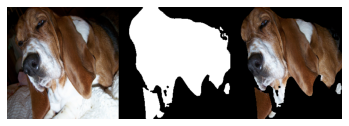

i= 21 loss= 0.0917968824505806 val_loss= 0.13276980817317963 mean_iou= 0.8831684589385986 val_mean_iou= 0.8371662497520447


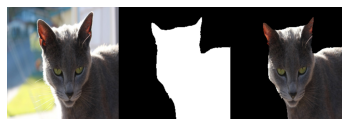

i= 22 loss= 0.09000049531459808 val_loss= 0.15159817039966583 mean_iou= 0.8839269280433655 val_mean_iou= 0.8283689618110657


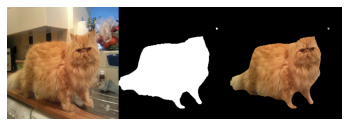

i= 23 loss= 0.08643227070569992 val_loss= 0.14760537445545197 mean_iou= 0.888832688331604 val_mean_iou= 0.8339681029319763


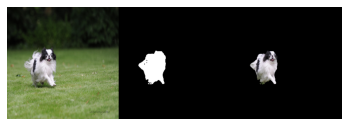

i= 24 loss= 0.08531945943832397 val_loss= 0.1528516709804535 mean_iou= 0.8902488350868225 val_mean_iou= 0.806966245174408


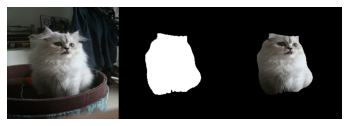

i= 25 loss= 0.08445116877555847 val_loss= 0.15226496756076813 mean_iou= 0.8898693919181824 val_mean_iou= 0.8241808414459229


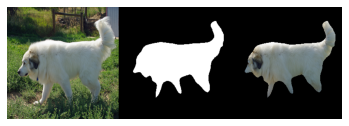

i= 26 loss= 0.08292286098003387 val_loss= 0.2038087248802185 mean_iou= 0.8911508917808533 val_mean_iou= 0.8006885647773743


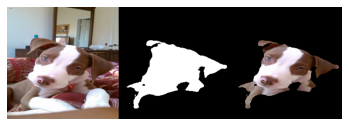

i= 27 loss= 0.07868177443742752 val_loss= 0.13157974183559418 mean_iou= 0.8966174125671387 val_mean_iou= 0.8357464075088501


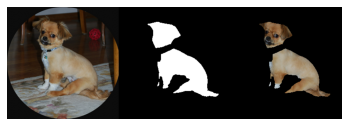

i= 28 loss= 0.07755481451749802 val_loss= 0.1430196464061737 mean_iou= 0.8977274894714355 val_mean_iou= 0.8299534320831299


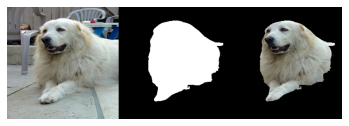

i= 29 loss= 0.07549428194761276 val_loss= 0.13762266933918 mean_iou= 0.9006392359733582 val_mean_iou= 0.8352817893028259


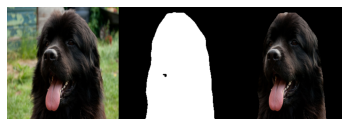

i= 30 loss= 0.07516061514616013 val_loss= 0.1564393937587738 mean_iou= 0.9018014669418335 val_mean_iou= 0.8402113318443298


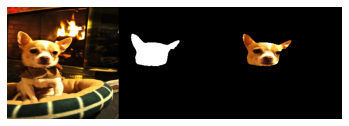

In [19]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

In [20]:
%cd /content/drive/MyDrive/Colab Notebooks/ICT 이노베이션 스퀘어/05 25 Unet/tensorflow 2.x 변환 코드

/content/drive/MyDrive/Colab Notebooks/ICT 이노베이션 스퀘어/05 25 Unet/tensorflow 2.x 변환 코드


In [21]:
model.save('MyUNet_residual_SE_210725.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
